Author: Nicolas Legrand <nicolas.legrand@cfin.au.dk>

In [46]:
%%capture
! pip install git+https://github.com/LegrandNico/metadPy.git

In [47]:
import os
import pandas as pd
import pingouin as pg
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from metadPy.utils import trials2counts
from metadPy.sdt import dprime

# Preprocessing

In [51]:
parent = os.path.join(os.getcwd(), os.pardir)
path = os.path.join(os.path.abspath(parent), 'Data', 'Raw')
subjects = [f for f in os.listdir(path) if len(f) == 5]

Extract confidence, response time, d prime and average accuracy and save in the `final_df` variable.

Extrac nR_S1 and nR_S2 vector for hierarchical bayesian estimation and save in the `metacog.txt` file.

During etraction, the following rules are applied to remove outliers, either in the trial or participant level:

* Trials with RTs faster than 100ms.

* Trial with RTs greater than 3 standard deviations than the median RT value.

In [52]:
final_df, metacog_df = pd.DataFrame([]), pd.DataFrame([])

for nSub in subjects:

    # Find files name
    for file in os.listdir(os.path.join(path, nSub)):
        if file.endswith(".txt") & file.startswith('Subject') & ('Block' not in file):
            df = pd.read_csv(os.path.join(path, nSub, file), na_values=['Nan'])

    # Start loop
    for val in ['High', 'Low']:

        for aro in ['High', 'Low']:
            
            # Filter for subject and conditions
            this_df = df.copy()[(df.Arousal == aro) & (df.Valence == val)]
            
            # Remove NaN values
            this_df = this_df[~((this_df.RT.isnull() | this_df.Confidence.isnull()))]
            
            # Drop fast RT
            this_df = this_df[(this_df.RT > .1)]
            
            # Reject slow trials median + 3 std
            this_df = this_df[this_df.RT < (this_df.RT.median() + (3 * this_df.RT.std()))]
            
            # Check enough trials remain
            if len(this_df)<50:
                raise ValueError

            #########
            # Metrics
            #########

            # Response time
            rt = this_df.RT.median()
            
            # Accuracy
            acc = (this_df.KeyPressed == this_df.Expected).mean()
            
            # Confidence
            conf = this_df.Confidence[~this_df.RT.isnull()].mean()
            
            # Extrac nR_S1 and nR_S2 vector and save separately
            stimID = this_df.Expected == 'right'
            responses = this_df.KeyPressed == 'right'
            confidence = this_df.Confidence
            nRatings = 7
            nR_S1, nR_S2 = trials2counts(stimuli=stimID, responses=responses, confidence=confidence, nRatings=nRatings)

            metacog_df = metacog_df.append(pd.DataFrame({'Subject': nSub,
                           'Valence': val,
                           'Arousal': aro,
                           'nR_S1': nR_S1,
                           'nR_S2': nR_S2,
                           'bins': np.arange(0, 14)}), ignore_index=True)

            final_df = final_df.append(pd.DataFrame({'Subject': [nSub],
                                                     'Valence': [val],
                                                     'Arousal': [aro],
                                                     'Confidence': [conf],
                                                     'RT': [rt],
                                                     'Keep': [len(this_df)/150],
                                                     'Accuracy': [acc]}), ignore_index=True)

out_path = os.path.join(os.path.abspath(parent), 'Data', 'Preprocessed', 'metacog.txt')
metacog_df.to_csv(out_path)

Here, we use the `metad.R` to fit hierarchical bayesian estimation of meta d' following the method described in:

    Fleming, S. M. (2017). HMeta-d: hierarchical Bayesian estimation of metacognitive efficiency from confidence ratings. *Neuroscience of Consciousness, 2017(1)*.

This script will save the results in `metadprim.txt`.

In [53]:
# Merge to final_df
metadprime_df = pd.read_csv(os.path.join(os.path.abspath(parent), 'Data', 'Preprocessed', 'metadprime.txt'), sep='\t')
metadprime_df.Subject = metadprime_df.Subject.astype(str)
final_df = pd.merge(final_df, metadprime_df, on=['Subject', 'Valence', 'Arousal'])

Check for the following criteria:

* Participants with mean d' less than or equal to 0.

* Participants with mean meta-d' less than or equal to 0.

In [54]:
assert ~(final_df.MetadPrime<=0).any()
assert ~(final_df.dPrime<=0).any()

* Participants whose values for d', confidence and response time on any condition are greater than 1.5 times the interquartile range.

In [55]:
reject = []
for metric in ['RT', 'dPrime', 'Confidence']:
    for val in ['High', 'Low']:

        for aro in ['High', 'Low']:
            
            this_df = final_df.copy().groupby(['Subject', 'Valence', 'Arousal'], as_index=False).mean()
            this_df = this_df[(this_df.Valence == val) & (this_df.Arousal == aro)]
            
            q1 = this_df[metric].quantile(.25)
            q3 = this_df[metric].quantile(.75)

            for sub in this_df.Subject[this_df[metric] > this_df[metric].quantile(.75) + ((q3 - q1) * 1.5)]:
                print(sub + ' - ' + metric)
                reject.append(sub)
            for sub in this_df.Subject[this_df[metric] < this_df[metric].quantile(.25) - ((q3 - q1) * 1.5)]:
                print(sub + ' - ' + metric)
                reject.append(sub)

11119 - RT
11138 - dPrime
11124 - dPrime
11131 - dPrime
47617 - dPrime


In [56]:
# Create reject vector
final_df['Reject'] = 0
for sub in reject:
    final_df.loc[final_df.Subject == sub, 'Reject'] = 1

* Check for extrem values in Hit and False alarm rates (under 0.05 or greater than 0.95).

In [57]:
assert ~(final_df.HR > 0.95).any()
assert ~(final_df.FAR < 0.05).any()

Reject outliers

In [58]:
final_df = final_df[final_df.Reject!=1]

Save dataframe

In [59]:
final_df.to_csv(os.path.join(os.path.abspath(parent), 'Data', 'Preprocessed', 'Behaviour.txt'))

Save as JASP format

In [60]:
jasp_df = []
for metric in ['RT', 'Criterion', 'Accuracy', 'Confidence', 'dPrime', 'MetadPrime', 'Mratio']:
    this_df = final_df.copy().pivot_table(index='Subject', columns=['Valence', 'Arousal'], values=metric).reset_index()
    cols = ['Subject']
    cols.extend([''.join((metric + '_', col[1], '_Aro_', col[0], 'Val')) for col in this_df.columns[1:]])
    this_df.columns = cols
    jasp_df.append(this_df)
jasp_df = pd.concat(jasp_df, axis=1)
jasp_df = jasp_df.loc[:,~jasp_df.columns.duplicated()]
jasp_df.to_csv(os.path.join(os.path.abspath(parent), 'Data', 'Preprocessed', 'JASP', 'behavior.txt'))

The statistical analyses reported in the paper are carried out using JASP, based on the data frames saved in the previous step. Here, we provide code snippets for interactive visualization and testing directly inside Binder. Although the results may slightly differ due to the statistical software used, no major difference are observed.

# Results

Compute % of drop.

In [61]:
((1 - final_df.Keep) * 100).mean(), ((1 - final_df.Keep) * 100).std()

(3.494444444444444, 3.687104571105834)

## Response time

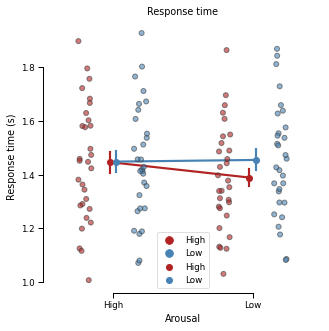

In [62]:
sns.set_context('paper')
plt.figure(figsize=(5, 5))
sns.stripplot(data=final_df, x='Arousal', y='RT', hue='Valence',
              palette=['firebrick', 'steelblue'], linewidth=1, dodge=True, alpha=.6)
sns.pointplot(data=final_df, x='Arousal', y='RT', hue='Valence',
              palette=['firebrick', 'steelblue'], dodge=True, ci=68)
plt.title('Response time')
plt.ylabel('Response time (s)')
sns.despine(trim=10)
plt.legend()

In [63]:
pg.rm_anova(data=final_df, subject='Subject', within=['Valence', 'Arousal'], dv='RT')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,Valence,0.033918,1,29,0.033918,5.547902,0.025480,0.025480,0.160586,1.0
1,Arousal,0.019615,1,29,0.019615,6.936505,0.013405,0.013405,0.193021,1.0
2,Valence * Arousal,0.030232,1,29,0.030232,7.558053,0.010175,0.010175,0.206741,1.0


In [64]:
pg.pairwise_ttests(data=final_df, subject='Subject', within=['Arousal', 'Valence'], dv='RT', effsize='cohen')

,Contrast,Arousal,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,cohen
0,Arousal,-,High,Low,True,True,2.633724,29.0,two-sided,0.013405,3.518,0.125914
1,Valence,-,High,Low,True,True,-2.355398,29.0,two-sided,0.025480,2.064,-0.163950
2,Arousal * Valence,High,High,Low,True,True,-0.110207,29.0,two-sided,0.913004,0.196,-0.008678
3,Arousal * Valence,Low,High,Low,True,True,-3.338741,29.0,two-sided,0.002322,15.815,-0.324337


# Criterion

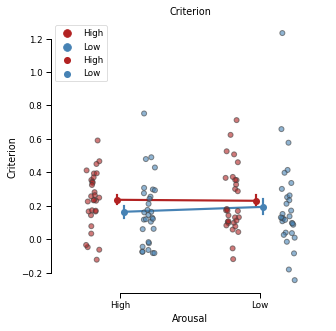

In [65]:
sns.set_context('paper')
plt.figure(figsize=(5, 5))
sns.stripplot(data=final_df, x='Arousal', y='Criterion', hue='Valence',
              palette=['firebrick', 'steelblue'], linewidth=1, dodge=True, alpha=.6)
sns.pointplot(data=final_df, x='Arousal', y='Criterion', hue='Valence',
              palette=['firebrick', 'steelblue'], dodge=True, ci=68)
plt.title('Criterion')
plt.ylabel('Criterion')
sns.despine(trim=10)
plt.legend()

In [66]:
pg.rm_anova(data=final_df, subject='Subject', within=['Valence', 'Arousal'], dv='Criterion')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,Valence,0.087550,1,29,0.087550,3.681868,0.064898,0.064898,0.112658,1.0
1,Arousal,0.004077,1,29,0.004077,0.360302,0.553001,0.553001,0.012272,1.0
2,Valence * Arousal,0.009331,1,29,0.009331,0.631317,0.433327,0.433327,0.021306,1.0


# Accuracy

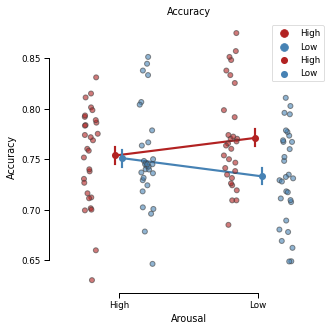

In [67]:
sns.set_context('paper')
plt.figure(figsize=(5, 5))
sns.stripplot(data=final_df, x='Arousal', y='Accuracy', hue='Valence',
              palette=['firebrick', 'steelblue'], linewidth=1, dodge=True, alpha=.6)
sns.pointplot(data=final_df, x='Arousal', y='Accuracy', hue='Valence',
              palette=['firebrick', 'steelblue'], dodge=True, ci=68)
plt.title('Accuracy')
plt.ylabel('Accuracy')
sns.despine(trim=10)
plt.legend()

In [68]:
pg.rm_anova(data=final_df, subject='Subject', within=['Valence', 'Arousal'], dv='Accuracy')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,Valence,0.012377,1,29,0.012377,9.886778,0.003824,0.003824,0.254245,1.0
1,Arousal,0.000003,1,29,0.000003,0.002049,0.964202,0.964202,0.000071,1.0
2,Valence * Arousal,0.009396,1,29,0.009396,7.799039,0.009160,0.009160,0.211936,1.0


In [69]:
pg.pairwise_ttests(data=final_df, subject='Subject', within=['Arousal', 'Valence'], dv='Accuracy', effsize='cohen')

,Contrast,Arousal,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,cohen
0,Arousal,-,High,Low,True,True,0.045270,29.0,two-sided,0.964202,0.195,0.007753
1,Valence,-,High,Low,True,True,3.144325,29.0,two-sided,0.003824,10.255,0.502896
2,Arousal * Valence,High,High,Low,True,True,0.287420,29.0,two-sided,0.775835,0.202,0.054529
3,Arousal * Valence,Low,High,Low,True,True,4.221369,29.0,two-sided,0.000219,128.303,0.790707


# Confidence

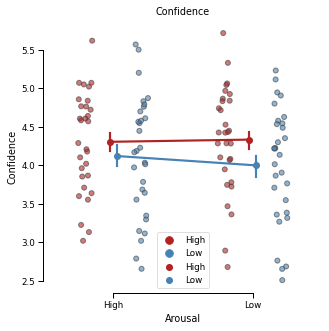

In [70]:
sns.set_context('paper')
plt.figure(figsize=(5, 5))
sns.stripplot(data=final_df, x='Arousal', y='Confidence', hue='Valence',
              palette=['firebrick', 'steelblue'], linewidth=1, dodge=True, alpha=.6)
sns.pointplot(data=final_df, x='Arousal', y='Confidence', hue='Valence',
              palette=['firebrick', 'steelblue'], dodge=True, ci=68)
plt.title('Confidence')
plt.ylabel('Confidence')
sns.despine(trim=10)
plt.legend()

In [71]:
pg.rm_anova(data=final_df, subject='Subject', within=['Valence', 'Arousal'], dv='Confidence')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,Valence,2.015384,1,29,2.015384,14.976366,0.000569,0.000569,0.340555,1.0
1,Arousal,0.065074,1,29,0.065074,0.777438,0.385176,0.385176,0.026108,1.0
2,Valence * Arousal,0.169135,1,29,0.169135,2.918643,0.098246,0.098246,0.091440,1.0


In [72]:
pg.pairwise_ttests(data=final_df, subject='Subject', within=['Arousal', 'Valence'], dv='Confidence', effsize='cohen')

,Contrast,Arousal,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,cohen
0,Arousal,-,High,Low,True,True,0.881724,29.0,two-sided,0.385176,0.278,0.067955
1,Valence,-,High,Low,True,True,3.869931,29.0,two-sided,0.000569,54.614,0.373158
2,Arousal * Valence,High,High,Low,True,True,2.379631,29.0,two-sided,0.024126,2.158,0.256417
3,Arousal * Valence,Low,High,Low,True,True,4.039126,29.0,two-sided,0.000360,82.165,0.463461


# D prime

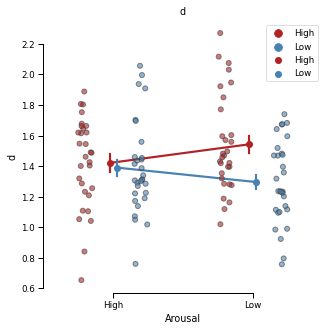

In [73]:
sns.set_context('paper')
plt.figure(figsize=(5, 5))
sns.stripplot(data=final_df, x='Arousal', y='dPrime', hue='Valence',
              palette=['firebrick', 'steelblue'], linewidth=1, dodge=True, alpha=.6)
sns.pointplot(data=final_df, x='Arousal', y='dPrime', hue='Valence',
              palette=['firebrick', 'steelblue'], dodge=True, ci=68)

plt.title('d')
plt.ylabel('d')
sns.despine(trim=10)
plt.legend()

In [74]:
pg.rm_anova(data=final_df, subject='Subject', within=['Valence', 'Arousal'], dv='dPrime')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,Valence,0.576603,1,29,0.576603,11.343894,0.002152,0.002152,0.281180,1.0
1,Arousal,0.005643,1,29,0.005643,0.098762,0.755570,0.755570,0.003394,1.0
2,Valence * Arousal,0.352807,1,29,0.352807,7.342599,0.011187,0.011187,0.202038,1.0


In [75]:
pg.pairwise_ttests(data=final_df, subject='Subject', within=['Arousal', 'Valence'], dv='dPrime', effsize='cohen')

,Contrast,Arousal,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,cohen
0,Arousal,-,High,Low,True,True,-0.314265,29.0,two-sided,0.755570,0.204,-0.054319
1,Valence,-,High,Low,True,True,3.368070,29.0,two-sided,0.002152,16.901,0.555989
2,Arousal * Valence,High,High,Low,True,True,0.522634,29.0,two-sided,0.605199,0.221,0.100865
3,Arousal * Valence,Low,High,Low,True,True,4.330970,29.0,two-sided,0.000162,168.153,0.836016


# Meta-d'

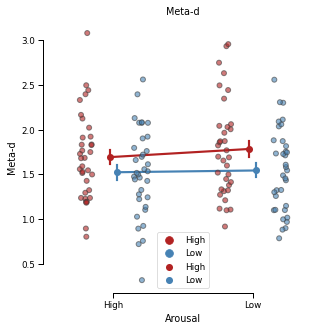

In [76]:
sns.set_context('paper')
plt.figure(figsize=(5, 5))
sns.stripplot(data=metadprime_df, x='Arousal', y='MetadPrime', hue='Valence',
               palette=['firebrick', 'steelblue'], linewidth=1, dodge=True, alpha=.6)
sns.pointplot(data=metadprime_df, x='Arousal', y='MetadPrime', hue='Valence',
              palette=['firebrick', 'steelblue'], dodge=True, ci=68)
plt.title('Meta-d')
plt.ylabel('Meta-d')
sns.despine(trim=10)
plt.legend()

In [77]:
pg.rm_anova(data=metadprime_df, subject='Subject', within=['Valence', 'Arousal'], dv='MetadPrime')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,Valence,1.467853,1,34,1.467853,12.579591,0.001161,0.001161,0.270067,1.0
1,Arousal,0.108339,1,34,0.108339,1.711340,0.199587,0.199587,0.047921,1.0
2,Valence * Arousal,0.044779,1,34,0.044779,0.477586,0.494209,0.494209,0.013852,1.0


In [78]:
pg.pairwise_ttests(data=metadprime_df, subject='Subject', within=['Arousal', 'Valence'], dv='MetadPrime', effsize='cohen')

,Contrast,Arousal,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,cohen
0,Arousal,-,High,Low,True,True,-1.308182,34.0,two-sided,0.199587,0.396,-0.126589
1,Valence,-,High,Low,True,True,3.546772,34.0,two-sided,0.001161,27.812,0.450649
2,Arousal * Valence,High,High,Low,True,True,2.416093,34.0,two-sided,0.021208,2.27,0.344644
3,Arousal * Valence,Low,High,Low,True,True,2.848554,34.0,two-sided,0.007403,5.525,0.480121


# M ratio

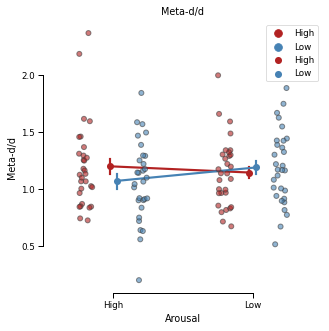

In [79]:
sns.set_context('paper')
plt.figure(figsize=(5, 5))
sns.stripplot(data=final_df, x='Arousal', y='Mratio', hue='Valence',
               palette=['firebrick', 'steelblue'], linewidth=1, dodge=True, alpha=.6)
sns.pointplot(data=final_df, x='Arousal', y='Mratio', hue='Valence',
              palette=['firebrick', 'steelblue'], dodge=True, ci=68)
plt.title('Meta-d/d')
plt.ylabel('Meta-d/d')
sns.despine(trim=10)
plt.legend()

In [80]:
pg.rm_anova(data=final_df, subject='Subject', within=['Valence', 'Arousal'], dv='Mratio')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,Valence,0.052251,1,29,0.052251,0.539208,0.468657,0.468657,0.018254,1.0
1,Arousal,0.029990,1,29,0.029990,0.259326,0.614437,0.614437,0.008863,1.0
2,Valence * Arousal,0.222731,1,29,0.222731,1.932529,0.175061,0.175061,0.062476,1.0


In [81]:
pg.pairwise_ttests(data=final_df, subject='Subject', within=['Arousal', 'Valence'], dv='Mratio', effsize='cohen')

,Contrast,Arousal,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,cohen
0,Arousal,-,High,Low,True,True,-0.509240,29.0,two-sided,0.614437,0.219,-0.127510
1,Valence,-,High,Low,True,True,0.734308,29.0,two-sided,0.468657,0.249,0.175112
2,Arousal * Valence,High,High,Low,True,True,1.572879,29.0,two-sided,0.126595,0.586,0.352469
3,Arousal * Valence,Low,High,Low,True,True,-0.511965,29.0,two-sided,0.612553,0.219,-0.142382
